In [14]:
import os, re, math, itertools, time
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
from keras.applications import EfficientNetB0

print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ambarish/breakhis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/breakhis


In [16]:
DATA_DIR = Path(path+"/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/")

OUT_DIR = Path("./breakhis_outputs")
TFRECORD_DIR = OUT_DIR / "tfrecords"
OUT_DIR.mkdir(parents=True, exist_ok=True)
TFRECORD_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (100, 100)      # (H, W)
BATCH_SIZE = 10
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# Magnification mapping
MAG2IDX = {"40X": 0, "100X": 1, "200X": 2, "400X": 3}
IDX2MAG = {v:k for k,v in MAG2IDX.items()}
NUM_MAGS = len(MAG2IDX)

# Split ratios (patient‑wise)
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

rng = np.random.default_rng(SEED)


In [17]:

def extract_patient_id(name: str) -> str:
    # e.g., SOB_B_A-14-22549-40X-001.png -> A-14
    m = re.search(r"(\d{2}-\d+)", name, flags=re.IGNORECASE)  #([AM]-?\d+)
    return m.group(1) if m else "UNK"

def extract_mag_token(name: str) -> str:
    # Accept '40X'/'40x' or delimiters like '-40-' or '_200X'
    m = re.search(r"(40|100|200|400)\s*[xX]\b", name)
    if m:
        return f"{m.group(1)}X"
    m2 = re.search(r"[-_](40|100|200|400)(?=[-_.])", name)
    if m2:
        return f"{m2.group(1)}X"
    return None

def scan_dataset(root: Path) -> pd.DataFrame:
    recs = []
    for label_name, label_id in (("benign",0), ("malignant",1)):
        base = root / label_name
        if not base.exists():
            print("Missing folder:", base)
            continue
        for p in base.rglob("*"):
            if p.suffix.lower() in [".png",".jpg",".jpeg",".tif",".tiff",".bmp"]:
                pid = extract_patient_id(p.name)
                mag_tok = extract_mag_token(p.name)
                mag_idx = MAG2IDX.get(mag_tok, -1)
                recs.append((str(p), label_id, label_name, pid, mag_idx))
    return pd.DataFrame(recs, columns=["filepath","label","label_name","patient_id","mag_idx"])

df = scan_dataset(DATA_DIR)
print("Total images:", len(df))
display(df.head())


Total images: 7909


,filepath,label,label_name,patient_id,mag_idx
0,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,0,benign,14-29960,2
1,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,0,benign,14-29960,2
2,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,0,benign,14-29960,2
3,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,0,benign,14-29960,2
4,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,0,benign,14-29960,2


In [18]:

# Basic counts
if len(df):
    print("\nLabel distribution:")
    print(df["label_name"].value_counts())

    print("\nMagnification distribution (idx -> count):")
    print(df["mag_idx"].value_counts().sort_index())

    print("\nPatients:", df["patient_id"].nunique())
else:
    print("No images found. Please set DATA_DIR correctly.")



Label distribution:
label_name
malignant    5429
benign       2480
Name: count, dtype: int64

Magnification distribution (idx -> count):
mag_idx
0    1995
1    2081
2    2013
3    1820
Name: count, dtype: int64

Patients: 70


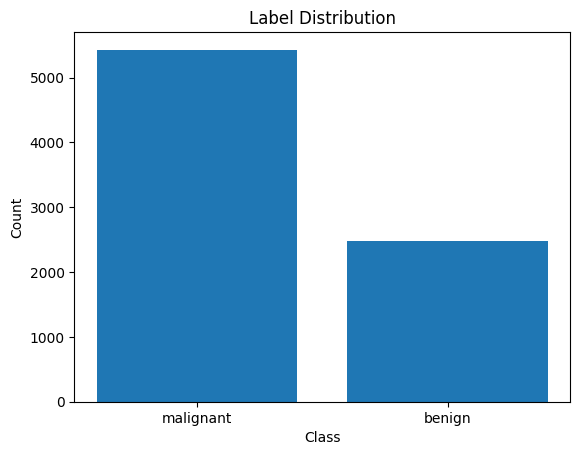

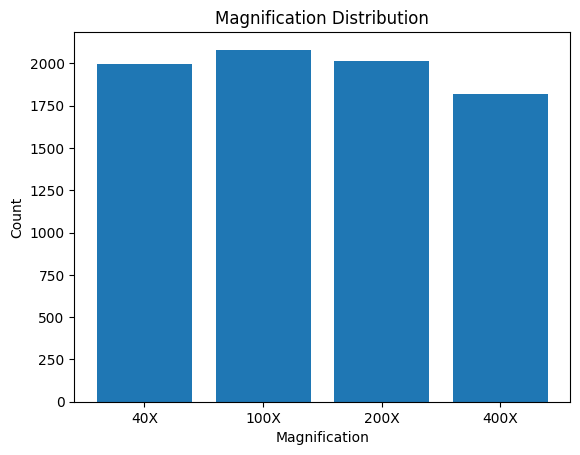

In [19]:

# Visualize distributions (simple bar charts)
def plot_bar(categories, counts, title, xlabel, ylabel):
    plt.figure()
    plt.bar(categories, counts)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.show()

if len(df):
    lbl_counts = df["label_name"].value_counts()
    plot_bar(lbl_counts.index.tolist(), lbl_counts.values.tolist(),
             "Label Distribution", "Class", "Count")

    mag_counts = df["mag_idx"].value_counts().sort_index()
    mags = [IDX2MAG.get(i, str(i)) for i in mag_counts.index.tolist()]
    plot_bar(mags, mag_counts.values.tolist(),
             "Magnification Distribution", "Magnification", "Count")


In [20]:

def patientwise_split(df: pd.DataFrame):
    patients = df["patient_id"].unique()
    # use the first sample's label per patient for stratification
    first = df.sort_values("filepath").drop_duplicates("patient_id")
    patient_labels = first.set_index("patient_id")["label"].reindex(patients).values

    # train vs temp (val+test)
    train_p, temp_p, y_train_p, y_temp_p = train_test_split(
        patients, patient_labels, test_size=(1.0-TRAIN_RATIO),
        stratify=patient_labels, random_state=SEED
    )
    # split temp into val/test 50/50 (for 15%/15% overall)
    val_p, test_p = train_test_split(
        temp_p, test_size=0.5, stratify=y_temp_p, random_state=SEED
    )

    df = df.copy()
    df["split"] = "train"
    df.loc[df["patient_id"].isin(val_p), "split"] = "val"
    df.loc[df["patient_id"].isin(test_p), "split"] = "test"
    return df, train_p, val_p, test_p

if len(df):
    df, train_p, val_p, test_p = patientwise_split(df)
    print(df["split"].value_counts())
else:
    print("Skipping split — empty dataframe.")


split
train    5715
val      1144
test     1050
Name: count, dtype: int64


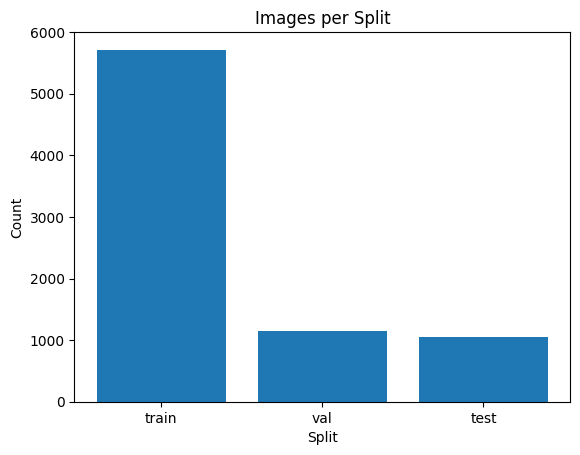

In [21]:

# Visualize counts per split
if "split" in df.columns and len(df):
    split_counts = df["split"].value_counts()[["train","val","test"]]
    plt.figure()
    plt.bar(split_counts.index.tolist(), split_counts.values.tolist())
    plt.title("Images per Split"); plt.xlabel("Split"); plt.ylabel("Count"); plt.show()


In [22]:

def _bytes_feature(v): return tf.train.Feature(bytes_list=tf.train.BytesList(value=[v]))
def _int64_feature(v): return tf.train.Feature(int64_list=tf.train.Int64List(value=[int(v)]))
def _string_feature(s: str): return tf.train.Feature(bytes_list=tf.train.BytesList(value=[s.encode("utf-8")]))

def write_tfrecord(df_split: pd.DataFrame, out_path: Path):
    n = len(df_split)
    with tf.io.TFRecordWriter(str(out_path)) as w:
        for i, (_, row) in enumerate(df_split.iterrows(), 1):
            # read & resize
            img = tf.io.read_file(row.filepath)
            img = tf.io.decode_image(img, channels=3, expand_animations=False)
            img = tf.image.resize(img, IMG_SIZE)
            img = tf.cast(tf.clip_by_value(tf.round(img), 0, 255), tf.uint8)
            img_bytes = tf.io.encode_jpeg(img).numpy()

            feat = {
                "image/encoded": _bytes_feature(img_bytes),
                "label": _int64_feature(row.label),
                "patient_id": _string_feature(row.patient_id),
                "magnification": _int64_feature(int(row.mag_idx)),
            }
            ex = tf.train.Example(features=tf.train.Features(feature=feat))
            w.write(ex.SerializeToString())
            if i % 1000 == 0 or i == n:
                print(f"{out_path.name}: {i}/{n}")

if len(df):
    for split in ["train","val","test"]:
        part = df[df["split"]==split]
        out_file = TFRECORD_DIR / f"{split}.tfrecord"
        write_tfrecord(part, out_file)
else:
    print("Skipping TFRecord writing — empty dataframe.")


train.tfrecord: 1000/5715
train.tfrecord: 2000/5715
train.tfrecord: 3000/5715
train.tfrecord: 4000/5715
train.tfrecord: 5000/5715
train.tfrecord: 5715/5715
val.tfrecord: 1000/1144
val.tfrecord: 1144/1144
test.tfrecord: 1000/1050
test.tfrecord: 1050/1050


In [23]:

FEATURES = {
    "image/encoded": tf.io.FixedLenFeature([], tf.string),
    "label": tf.io.FixedLenFeature([], tf.int64),
    "patient_id": tf.io.FixedLenFeature([], tf.string),
    "magnification": tf.io.FixedLenFeature([], tf.int64),
}

def parse_example(serialized):
    ex = tf.io.parse_single_example(serialized, FEATURES)
    img = tf.io.decode_jpeg(ex["image/encoded"], channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    label = tf.cast(ex["label"], tf.float32)
    mag_idx = tf.cast(ex["magnification"], tf.int32)
    mag_1h = tf.one_hot(mag_idx, depth=NUM_MAGS)
    return img, (label, mag_1h)

def augment(image, targets):
    label, mag_1h = targets
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.15)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    # random 0/90/180/270
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    return image, (label, mag_1h)

def to_model_io(image, targets):
    label, mag_1h = targets
    return {"image": image, "mag": mag_1h}, label


In [24]:

def make_dataset(split: str, training=False, batch_size=BATCH_SIZE):
    path = TFRECORD_DIR / f"{split}.tfrecord"
    ds = tf.data.TFRecordDataset(str(path))
    ds = ds.map(parse_example, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(4096, seed=SEED)
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.map(to_model_io, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

if len(df):
    train_ds = make_dataset("train", training=True)
    val_ds   = make_dataset("val")
    test_ds  = make_dataset("test")


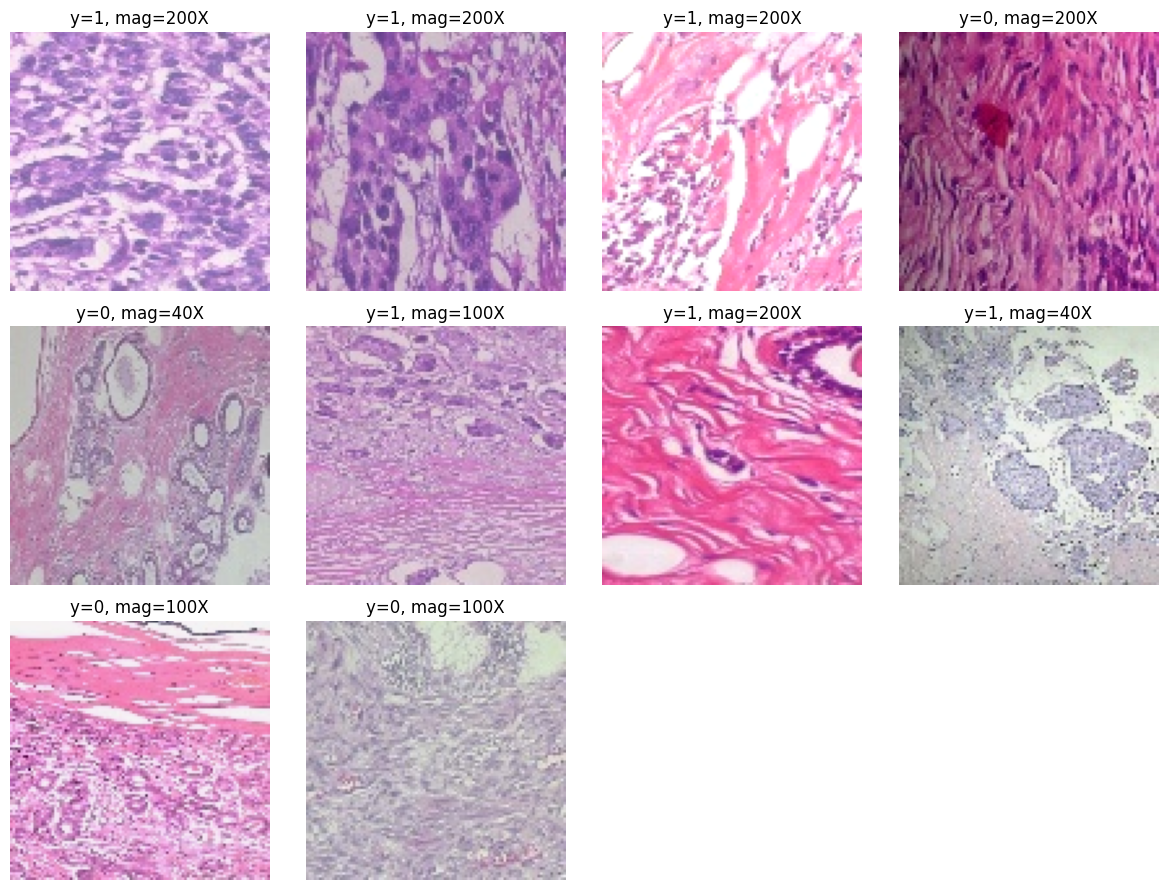

In [25]:

# Visualize a batch of augmented images with labels + magnification
if len(df):
    batch = next(iter(train_ds))
    x, y = batch
    imgs = x["image"]
    mags = tf.argmax(x["mag"], axis=1).numpy()
    labels = y.numpy().astype(int)

    n = min(12, imgs.shape[0])
    cols = 4
    rows = math.ceil(n/cols)
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i].numpy())
        plt.title(f"y={labels[i]}, mag={IDX2MAG[mags[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [26]:
from keras import layers, models, regularizers
from keras.applications import DenseNet201
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

def build_densenet_model(img_size=(100, 100), num_mags=4):
    base_model = DenseNet201(
        weights="imagenet",
        include_top=False,
        input_shape=(img_size[0], img_size[1], 3)
    )

    base_model.trainable = True
    for layer in base_model.layers[:150]:
        layer.trainable = False

    img_in = layers.Input(shape=(img_size[0], img_size[1], 3), name="image")
    mag_in = layers.Input(shape=(num_mags,), name="mag")

    x = base_model(img_in)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(712, activation='elu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    m = layers.Dense(128, activation="elu")(mag_in)
    m = layers.BatchNormalization()(m)
    m = layers.Dropout(0.3)(m)
    m = layers.Dense(64, activation="elu")(m)



    z = layers.Concatenate()([x, m])
    z = layers.Dense(156, activation="elu", kernel_regularizer=regularizers.l2(1e-4))(z)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.4)(z)
    z = layers.Dense(128, activation="elu")(z)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.4)(z)
    out = layers.Dense(1, activation="sigmoid")(z)

    model = models.Model(inputs={"image": img_in, "mag": mag_in}, outputs=out)
    return model

model = build_densenet_model()
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 100, 100,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet201         │ (None, 3, 3,      │ 18,321,984 │ image[0][0]       │
│ (Functional)        │ 1920)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mag (InputLayer)    │ (None, 4)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1920)      │          0 │ densenet201[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │        640 │ mag[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 712)       │  1,367,752 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 712)       │      2,848 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 712)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 776)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 156)       │    121,212 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 156)       │        624 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 156)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     20,096 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        129 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,844,565 (75.70 MB)

 Trainable params: 18,112,653 (69.09 MB)

 Non-trainable params: 1,731,912 (6.61 MB)

In [27]:
if len(df):
    # --- Class weights ---
    train_labels = df[df["split"] == "train"]["label"].values
    n0 = (train_labels == 0).sum()
    n1 = (train_labels == 1).sum()
    total = n0 + n1 if (n0 + n1) > 0 else 1
    class_weight = {0: total / (2 * max(n0, 1)), 1: total / (2 * max(n1, 1))}
    print("Class weights:", class_weight)

    # --- Callbacks ---
    ckpt_path = str(OUT_DIR / "best_custom_cnn.keras")
    callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_densenet_model.h5', monitor='val_accuracy', save_best_only=True)
]

    # --- Compile model ---
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name="acc"),
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(name="prec"),
            tf.keras.metrics.Recall(name="rec"),
        ],
    )

    # --- Train ---
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        class_weight=class_weight,
        callbacks=callbacks,
    )



Class weights: {0: np.float64(1.4280359820089954), 1: np.float64(0.7693861066235864)}
Epoch 1/30
    572/Unknown 616s 475ms/step - acc: 0.7033 - auc: 0.7797 - loss: 0.7424 - prec: 0.7917 - rec: 0.6814

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


572/572 ━━━━━━━━━━━━━━━━━━━━ 672s 573ms/step - acc: 0.7034 - auc: 0.7798 - loss: 0.7422 - prec: 0.7918 - rec: 0.6815 - val_acc: 0.8829 - val_auc: 0.9518 - val_loss: 0.3938 - val_prec: 0.9717 - val_rec: 0.8821 - learning_rate: 0.0010
Epoch 2/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.8159 - auc: 0.8866 - loss: 0.5288 - prec: 0.8772 - rec: 0.8120

572/572 ━━━━━━━━━━━━━━━━━━━━ 48s 80ms/step - acc: 0.8159 - auc: 0.8866 - loss: 0.5288 - prec: 0.8772 - rec: 0.8120 - val_acc: 0.9257 - val_auc: 0.9335 - val_loss: 0.2982 - val_prec: 0.9569 - val_rec: 0.9518 - learning_rate: 0.0010
Epoch 3/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.8498 - auc: 0.9183 - loss: 0.4477 - prec: 0.9027 - rec: 0.8445

572/572 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - acc: 0.8498 - auc: 0.9183 - loss: 0.4477 - prec: 0.9027 - rec: 0.8445 - val_acc: 0.8584 - val_auc: 0.8515 - val_loss: 0.4591 - val_prec: 0.9269 - val_rec: 0.8971 - learning_rate: 0.0010
Epoch 4/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.8577 - auc: 0.9252 - loss: 0.4317 - prec: 0.9114 - rec: 0.8509

572/572 ━━━━━━━━━━━━━━━━━━━━ 51s 86ms/step - acc: 0.8577 - auc: 0.9252 - loss: 0.4316 - prec: 0.9115 - rec: 0.8509 - val_acc: 0.9012 - val_auc: 0.9422 - val_loss: 0.2977 - val_prec: 0.9447 - val_rec: 0.9335 - learning_rate: 0.0010
Epoch 5/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - acc: 0.8733 - auc: 0.9390 - loss: 0.3889 - prec: 0.9174 - rec: 0.8635

572/572 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - acc: 0.8733 - auc: 0.9390 - loss: 0.3889 - prec: 0.9174 - rec: 0.8636 - val_acc: 0.9362 - val_auc: 0.9939 - val_loss: 0.2326 - val_prec: 0.9954 - val_rec: 0.9260 - learning_rate: 0.0010
Epoch 6/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.8862 - auc: 0.9487 - loss: 0.3517 - prec: 0.9252 - rec: 0.8863

572/572 ━━━━━━━━━━━━━━━━━━━━ 82s 87ms/step - acc: 0.8862 - auc: 0.9487 - loss: 0.3517 - prec: 0.9253 - rec: 0.8863 - val_acc: 0.8715 - val_auc: 0.9790 - val_loss: 0.3465 - val_prec: 0.9925 - val_rec: 0.8489 - learning_rate: 0.0010
Epoch 7/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - acc: 0.8931 - auc: 0.9540 - loss: 0.3214 - prec: 0.9373 - rec: 0.8857

572/572 ━━━━━━━━━━━━━━━━━━━━ 49s 84ms/step - acc: 0.8931 - auc: 0.9540 - loss: 0.3214 - prec: 0.9373 - rec: 0.8857 - val_acc: 0.9213 - val_auc: 0.9804 - val_loss: 0.2174 - val_prec: 0.9817 - val_rec: 0.9207 - learning_rate: 0.0010
Epoch 8/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.8911 - auc: 0.9538 - loss: 0.3241 - prec: 0.9301 - rec: 0.8848

572/572 ━━━━━━━━━━━━━━━━━━━━ 84s 88ms/step - acc: 0.8911 - auc: 0.9538 - loss: 0.3241 - prec: 0.9301 - rec: 0.8848 - val_acc: 0.9388 - val_auc: 0.9599 - val_loss: 0.2096 - val_prec: 0.9625 - val_rec: 0.9625 - learning_rate: 0.0010
Epoch 9/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.9024 - auc: 0.9596 - loss: 0.2955 - prec: 0.9485 - rec: 0.8905

572/572 ━━━━━━━━━━━━━━━━━━━━ 82s 141ms/step - acc: 0.9024 - auc: 0.9596 - loss: 0.2954 - prec: 0.9485 - rec: 0.8905 - val_acc: 0.9152 - val_auc: 0.9499 - val_loss: 0.2420 - val_prec: 0.9563 - val_rec: 0.9389 - learning_rate: 0.0010
Epoch 10/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.9090 - auc: 0.9612 - loss: 0.2818 - prec: 0.9525 - rec: 0.8967

572/572 ━━━━━━━━━━━━━━━━━━━━ 80s 138ms/step - acc: 0.9090 - auc: 0.9612 - loss: 0.2818 - prec: 0.9525 - rec: 0.8967 - val_acc: 0.9231 - val_auc: 0.8804 - val_loss: 0.2856 - val_prec: 0.9351 - val_rec: 0.9732 - learning_rate: 0.0010
Epoch 11/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.9060 - auc: 0.9621 - loss: 0.2842 - prec: 0.9379 - rec: 0.9060

572/572 ━━━━━━━━━━━━━━━━━━━━ 53s 91ms/step - acc: 0.9060 - auc: 0.9621 - loss: 0.2842 - prec: 0.9379 - rec: 0.9060 - val_acc: 0.8864 - val_auc: 0.9503 - val_loss: 0.2895 - val_prec: 0.9663 - val_rec: 0.8917 - learning_rate: 0.0010
Epoch 12/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.9101 - auc: 0.9649 - loss: 0.2791 - prec: 0.9424 - rec: 0.9071

572/572 ━━━━━━━━━━━━━━━━━━━━ 86s 98ms/step - acc: 0.9101 - auc: 0.9649 - loss: 0.2791 - prec: 0.9425 - rec: 0.9072 - val_acc: 0.9388 - val_auc: 0.9657 - val_loss: 0.1903 - val_prec: 0.9490 - val_rec: 0.9775 - learning_rate: 0.0010
Epoch 13/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.9197 - auc: 0.9686 - loss: 0.2568 - prec: 0.9531 - rec: 0.9128

572/572 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - acc: 0.9197 - auc: 0.9687 - loss: 0.2567 - prec: 0.9531 - rec: 0.9128 - val_acc: 0.9309 - val_auc: 0.9708 - val_loss: 0.2248 - val_prec: 0.9703 - val_rec: 0.9443 - learning_rate: 0.0010
Epoch 14/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - acc: 0.9076 - auc: 0.9642 - loss: 0.2706 - prec: 0.9460 - rec: 0.8985

572/572 ━━━━━━━━━━━━━━━━━━━━ 88s 98ms/step - acc: 0.9076 - auc: 0.9642 - loss: 0.2705 - prec: 0.9460 - rec: 0.8985 - val_acc: 0.9003 - val_auc: 0.9174 - val_loss: 0.2896 - val_prec: 0.9427 - val_rec: 0.9346 - learning_rate: 0.0010
Epoch 15/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - acc: 0.9150 - auc: 0.9714 - loss: 0.2493 - prec: 0.9476 - rec: 0.9107

572/572 ━━━━━━━━━━━━━━━━━━━━ 82s 99ms/step - acc: 0.9150 - auc: 0.9714 - loss: 0.2493 - prec: 0.9476 - rec: 0.9107 - val_acc: 0.9379 - val_auc: 0.9665 - val_loss: 0.2085 - val_prec: 0.9527 - val_rec: 0.9721 - learning_rate: 0.0010
Epoch 16/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - acc: 0.9232 - auc: 0.9690 - loss: 0.2543 - prec: 0.9525 - rec: 0.9197

572/572 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - acc: 0.9232 - auc: 0.9690 - loss: 0.2543 - prec: 0.9525 - rec: 0.9197 - val_acc: 0.9292 - val_auc: 0.9696 - val_loss: 0.2180 - val_prec: 0.9723 - val_rec: 0.9400 - learning_rate: 0.0010
Epoch 17/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.9201 - auc: 0.9698 - loss: 0.2527 - prec: 0.9451 - rec: 0.9189

572/572 ━━━━━━━━━━━━━━━━━━━━ 117s 98ms/step - acc: 0.9201 - auc: 0.9698 - loss: 0.2526 - prec: 0.9451 - rec: 0.9189 - val_acc: 0.9309 - val_auc: 0.9115 - val_loss: 0.2564 - val_prec: 0.9331 - val_rec: 0.9861 - learning_rate: 0.0010
Epoch 18/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.9370 - auc: 0.9798 - loss: 0.2086 - prec: 0.9522 - rec: 0.9422

572/572 ━━━━━━━━━━━━━━━━━━━━ 82s 98ms/step - acc: 0.9370 - auc: 0.9798 - loss: 0.2086 - prec: 0.9523 - rec: 0.9422 - val_acc: 0.9353 - val_auc: 0.9587 - val_loss: 0.1946 - val_prec: 0.9442 - val_rec: 0.9786 - learning_rate: 2.0000e-04
Epoch 19/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - acc: 0.9531 - auc: 0.9846 - loss: 0.1714 - prec: 0.9709 - rec: 0.9515

572/572 ━━━━━━━━━━━━━━━━━━━━ 77s 89ms/step - acc: 0.9531 - auc: 0.9846 - loss: 0.1714 - prec: 0.9710 - rec: 0.9515 - val_acc: 0.9371 - val_auc: 0.9571 - val_loss: 0.1888 - val_prec: 0.9379 - val_rec: 0.9882 - learning_rate: 2.0000e-04
Epoch 20/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.9514 - auc: 0.9862 - loss: 0.1574 - prec: 0.9685 - rec: 0.9513

572/572 ━━━━━━━━━━━━━━━━━━━━ 87s 151ms/step - acc: 0.9514 - auc: 0.9862 - loss: 0.1574 - prec: 0.9685 - rec: 0.9513 - val_acc: 0.9371 - val_auc: 0.9625 - val_loss: 0.1803 - val_prec: 0.9406 - val_rec: 0.9850 - learning_rate: 2.0000e-04
Epoch 21/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.9559 - auc: 0.9866 - loss: 0.1569 - prec: 0.9750 - rec: 0.9519

572/572 ━━━━━━━━━━━━━━━━━━━━ 110s 96ms/step - acc: 0.9559 - auc: 0.9866 - loss: 0.1568 - prec: 0.9750 - rec: 0.9519 - val_acc: 0.9327 - val_auc: 0.9465 - val_loss: 0.2193 - val_prec: 0.9350 - val_rec: 0.9861 - learning_rate: 2.0000e-04
Epoch 22/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.9638 - auc: 0.9896 - loss: 0.1349 - prec: 0.9805 - rec: 0.9610

572/572 ━━━━━━━━━━━━━━━━━━━━ 138s 195ms/step - acc: 0.9638 - auc: 0.9896 - loss: 0.1349 - prec: 0.9805 - rec: 0.9610 - val_acc: 0.9336 - val_auc: 0.9550 - val_loss: 0.1970 - val_prec: 0.9368 - val_rec: 0.9850 - learning_rate: 2.0000e-04
Epoch 23/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - acc: 0.9649 - auc: 0.9889 - loss: 0.1353 - prec: 0.9821 - rec: 0.9602

572/572 ━━━━━━━━━━━━━━━━━━━━ 53s 90ms/step - acc: 0.9649 - auc: 0.9889 - loss: 0.1353 - prec: 0.9821 - rec: 0.9602 - val_acc: 0.9292 - val_auc: 0.9586 - val_loss: 0.2091 - val_prec: 0.9329 - val_rec: 0.9839 - learning_rate: 2.0000e-04
Epoch 24/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - acc: 0.9620 - auc: 0.9911 - loss: 0.1253 - prec: 0.9772 - rec: 0.9598

572/572 ━━━━━━━━━━━━━━━━━━━━ 148s 205ms/step - acc: 0.9620 - auc: 0.9911 - loss: 0.1253 - prec: 0.9772 - rec: 0.9598 - val_acc: 0.9327 - val_auc: 0.9411 - val_loss: 0.2320 - val_prec: 0.9350 - val_rec: 0.9861 - learning_rate: 2.0000e-04
Epoch 25/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - acc: 0.9628 - auc: 0.9890 - loss: 0.1435 - prec: 0.9759 - rec: 0.9610

572/572 ━━━━━━━━━━━━━━━━━━━━ 80s 99ms/step - acc: 0.9628 - auc: 0.9890 - loss: 0.1435 - prec: 0.9759 - rec: 0.9611 - val_acc: 0.9266 - val_auc: 0.9510 - val_loss: 0.2210 - val_prec: 0.9318 - val_rec: 0.9818 - learning_rate: 2.0000e-04
Epoch 26/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.9616 - auc: 0.9869 - loss: 0.1499 - prec: 0.9737 - rec: 0.9599

572/572 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - acc: 0.9616 - auc: 0.9869 - loss: 0.1499 - prec: 0.9738 - rec: 0.9599 - val_acc: 0.9318 - val_auc: 0.9537 - val_loss: 0.2043 - val_prec: 0.9349 - val_rec: 0.9850 - learning_rate: 4.0000e-05
Epoch 27/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - acc: 0.9601 - auc: 0.9893 - loss: 0.1302 - prec: 0.9781 - rec: 0.9567

572/572 ━━━━━━━━━━━━━━━━━━━━ 88s 152ms/step - acc: 0.9601 - auc: 0.9893 - loss: 0.1302 - prec: 0.9782 - rec: 0.9567 - val_acc: 0.9327 - val_auc: 0.9591 - val_loss: 0.2006 - val_prec: 0.9341 - val_rec: 0.9871 - learning_rate: 4.0000e-05
Epoch 28/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - acc: 0.9699 - auc: 0.9907 - loss: 0.1434 - prec: 0.9798 - rec: 0.9702

572/572 ━━━━━━━━━━━━━━━━━━━━ 57s 98ms/step - acc: 0.9699 - auc: 0.9907 - loss: 0.1434 - prec: 0.9799 - rec: 0.9702 - val_acc: 0.9318 - val_auc: 0.9459 - val_loss: 0.2156 - val_prec: 0.9340 - val_rec: 0.9861 - learning_rate: 4.0000e-05
Epoch 29/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.9738 - auc: 0.9933 - loss: 0.0997 - prec: 0.9855 - rec: 0.9720

572/572 ━━━━━━━━━━━━━━━━━━━━ 82s 99ms/step - acc: 0.9738 - auc: 0.9933 - loss: 0.0997 - prec: 0.9855 - rec: 0.9720 - val_acc: 0.9318 - val_auc: 0.9521 - val_loss: 0.1986 - val_prec: 0.9376 - val_rec: 0.9818 - learning_rate: 4.0000e-05
Epoch 30/30
572/572 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - acc: 0.9705 - auc: 0.9942 - loss: 0.0982 - prec: 0.9849 - rec: 0.9662

572/572 ━━━━━━━━━━━━━━━━━━━━ 82s 141ms/step - acc: 0.9705 - auc: 0.9942 - loss: 0.0982 - prec: 0.9849 - rec: 0.9662 - val_acc: 0.9318 - val_auc: 0.9520 - val_loss: 0.2104 - val_prec: 0.9358 - val_rec: 0.9839 - learning_rate: 4.0000e-05


Best threshold (F1-optimal): 0.873
Test Accuracy: 0.9228571428571428
Test AUC: 0.9484387525289155

Confusion Matrix:
 [[229  39]
 [ 42 740]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8450    0.8545    0.8497       268
           1     0.9499    0.9463    0.9481       782

    accuracy                         0.9229      1050
   macro avg     0.8975    0.9004    0.8989      1050
weighted avg     0.9232    0.9229    0.9230      1050



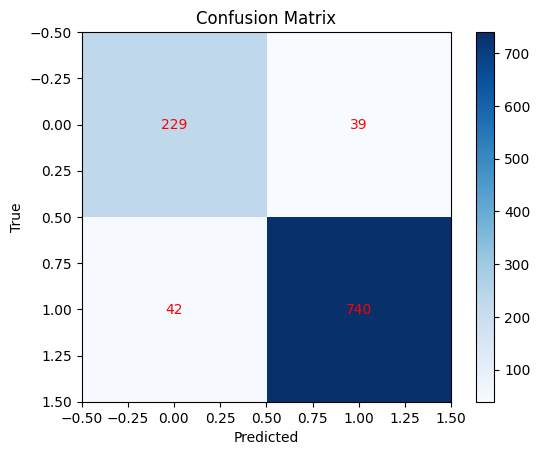

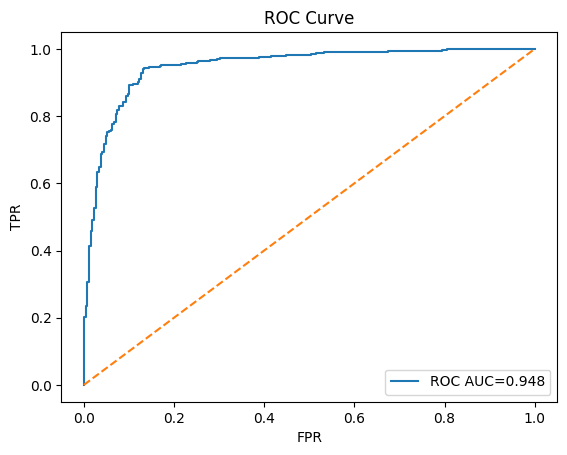

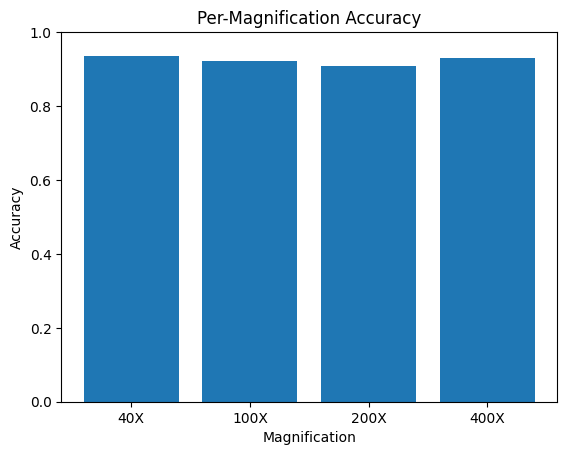

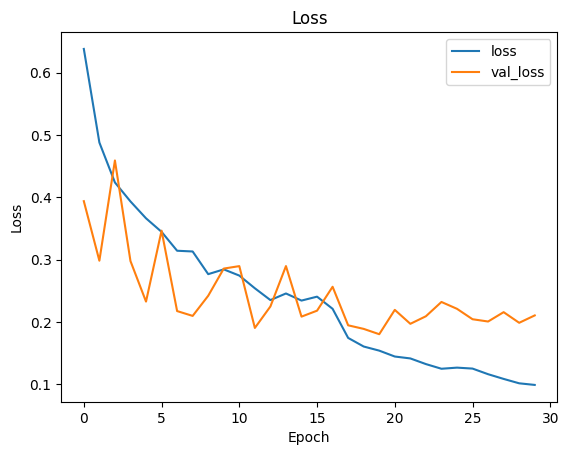

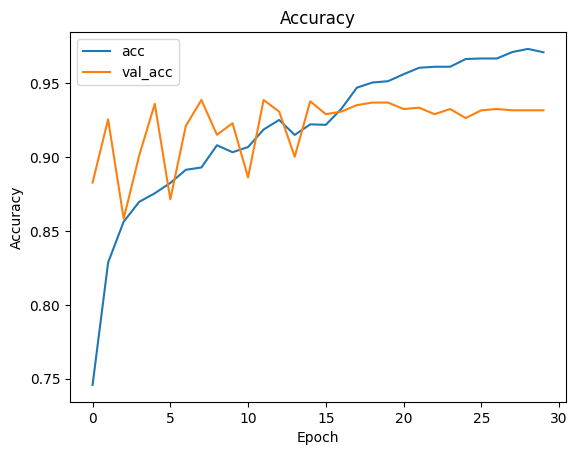

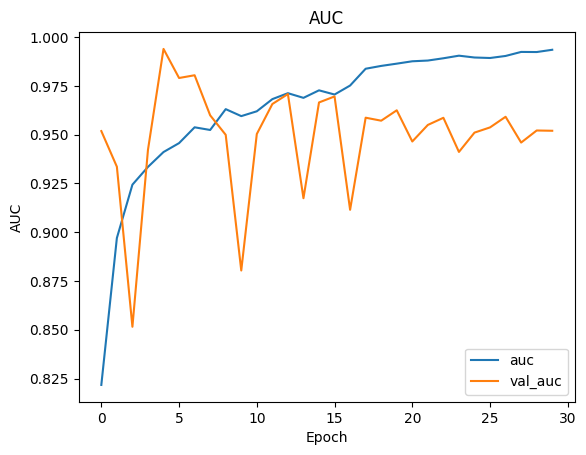

In [28]:
from sklearn.metrics import precision_recall_curve
# ========================
# Evaluation on Test set
# ========================
if len(df):
    y_true, y_prob, y_pred, mag_all = [], [], [], []

    for batch in test_ds:
        x, y = batch
        p = model.predict(x, verbose=0).ravel()
        y_prob.extend(p.tolist())
        y_true.extend(y.numpy().tolist())
        y_pred.extend((p >= 0.5).astype(int).tolist())  # Default threshold = 0.5
        mag_all.extend(tf.argmax(x["mag"], axis=1).numpy().tolist())

    y_true = np.array(y_true, dtype=int)
    y_pred = np.array(y_pred, dtype=int)
    y_prob = np.array(y_prob, dtype=float)
    mag_all = np.array(mag_all, dtype=int)

    # --- Find best threshold (optional) ---
    if len(np.unique(y_true)) > 1:
        prec, rec, th = precision_recall_curve(y_true, y_prob)
        f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
        best_idx = np.argmax(f1)
        best_thresh = th[best_idx]
        print(f"Best threshold (F1-optimal): {best_thresh:.3f}")
        # Recompute preds
        y_pred = (y_prob >= best_thresh).astype(int)

    # --- Metrics ---
    acc = (y_true == y_pred).mean()
    auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else float("nan")
    cm = confusion_matrix(y_true, y_pred)

    print("Test Accuracy:", acc)
    print("Test AUC:", auc)
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

    # --- Confusion Matrix heatmap ---
    plt.figure()
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha="center", va="center", color="red")
    plt.colorbar()
    plt.show()

    # --- ROC Curve ---
    if len(np.unique(y_true)) > 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC AUC={auc:.3f}")
        plt.plot([0, 1], [0, 1], "--")
        plt.title("ROC Curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend()
        plt.show()

    # --- Per-Magnification Accuracy ---
    accs = []
    mags_labels = [IDX2MAG[i] for i in range(NUM_MAGS)]
    for idx in range(NUM_MAGS):
        mask = mag_all == idx
        if mask.sum() > 0:
            accs.append((y_true[mask] == y_pred[mask]).mean())
        else:
            accs.append(0.0)

    plt.figure()
    plt.bar(mags_labels, accs)
    plt.title("Per-Magnification Accuracy")
    plt.xlabel("Magnification")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.show()

    # --- Training curves ---
    if "history" in globals():
        plt.figure()
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(["loss", "val_loss"])
        plt.show()

        plt.figure()
        plt.plot(history.history["acc"])
        plt.plot(history.history["val_acc"])
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(["acc", "val_acc"])
        plt.show()

        plt.figure()
        plt.plot(history.history["auc"])
        plt.plot(history.history["val_auc"])
        plt.title("AUC")
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.legend(["auc", "val_auc"])
        plt.show()

